### 多项式曲线拟合
我们从最基础的机器学习方法来回忆机器学习课上的知识，最基本的算法莫过于函数拟合了。多项式回归涉及到的知识是数据预处理(高维映射、归一化、标准化)、均方误差MSE的使用、代数方程求解和数值优化方法的使用。如果要寻找合适的多项式阶数可能还要用到正则化技巧和验证集来辅助训练。  
首先我们把原数据进行升维到M阶，并且设置偏置项(实际上这种方法并不仅限于多项式，我们可以随意对X和y进行我们希望的变换，建立一个任意的线性组合的函数形式，再进行回归)然后按照线性回归的做法就能计算多项式的回归。线性回归的过程等价于最小化均方误差，写出等式可以解正规方程。$$ f(x)=XW $$  
$$ W = argmin \quad L(W)$$ $$ L(W)= (y-XW)^T(y-XW) $$  
因为优化目标函数是凸优化，直接计算偏导为0就能得到闭式解。$$ \frac{\partial L}{\partial W}= 2X^T(XW-y)=0 $$  
$$ W = (X^{T}X)^{-1}X^Ty $$  
当然也可以直接用上面的梯度进行数值优化，进行多次梯度下降也可以得到一个稳定的解。这个方法在某些数据中某些维度出现缺失时也适用，而不用担心矩阵不完整的问题。如果要在上面的基础上再使用正则化，以L2正则为例，我们在损失函数MSE的基础上增加了一项$$\lambda W^TW$$惩罚项，这个方法能有效减小过拟合。再次计算梯度如下，我们就得到了新的，带正则化项的闭式解
$$ \frac{\partial L}{\partial W}= 2X^T(XW-y)+2\lambda W=0 $$  
$$ W = (X^{T}X+\lambda I)^{-1}(X^Ty) $$  
公式已经给出，下面我们借助这个闭式解，直接写一个多项式回归的算法。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
def combination(deg,n):
    '''
    生成多个m长度的list，每个list都是和为m的任意组合
    '''
    if n==1:
        return [[deg]]
    ret = []
    for i in range(deg+1):
        for postfix in combination(deg-i,n-1):
            ret.append([i]+postfix)
    return ret

In [3]:
combination(2,4)

[[0, 0, 0, 2],
 [0, 0, 1, 1],
 [0, 0, 2, 0],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [0, 2, 0, 0],
 [1, 0, 0, 1],
 [1, 0, 1, 0],
 [1, 1, 0, 0],
 [2, 0, 0, 0]]

In [4]:
def dim_improve(X_raw, deg):
    '''
    多项式维度提升的算法，对X_raw里的维度都计算0~deg次方
    '''
    n,m = X_raw.shape
    X = []
    for j in range(deg+1):
        # 遍历0到deg阶的所有组合
        combs = combination(j,m)
        for comb in combs:
            prod = 1
            for i in range(m):
                prod *= X_raw[:,i]**comb[i]
            X.append(prod)

    X = np.array(X).T
    return X

In [5]:
X_raw = np.array([[1],[2],[3]])
dim_improve(X_raw, 3)

array([[ 1,  1,  1,  1],
       [ 1,  2,  4,  8],
       [ 1,  3,  9, 27]], dtype=int32)

In [6]:
X_raw = np.array([[1,2],[4,3]])
dim_improve(X_raw, 2)

array([[ 1,  2,  1,  4,  2,  1],
       [ 1,  3,  4,  9, 12, 16]], dtype=int32)

In [7]:
def poly_fitting(X_raw, y, poly_degree, lamda = 0, plot = False):
    '''
    X raw，y;给定的数据集，需要提升阶数，默认X,y为2维numpy array
    poly degree;拟合的多项式最高阶数
    lambda:L2正则的系数，系数越大惩罚越强
    返回多项式权重向量，维度为poly degree+1
    '''
    deg = poly_degree
    # 首先提升维度，并增加偏置项
    X = dim_improve(X_raw,deg)
    
    n,m = X.shape
    W = np.linalg.inv(X.T.dot(X)+lamda*np.eye(m)).dot(X.T.dot(y))
    
    if plot:
        if X_raw.shape[1]>1:
            print("Can not plot data more than 1 dimension.")
        else:
            plt.figure()
            x_space_raw = np.linspace(np.min(X_raw),np.max(X_raw),100).reshape(-1,1)
            x_space = dim_improve(x_space_raw,deg)
            y_space = x_space.dot(W)
            plt.plot(x_space_raw, y_space)
            plt.scatter(X_raw, y, c = 'r', marker = 'x')
        
    return X,W

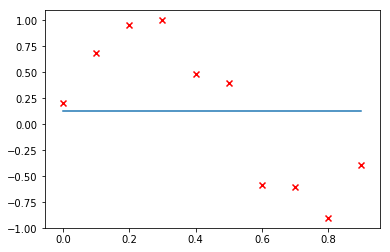

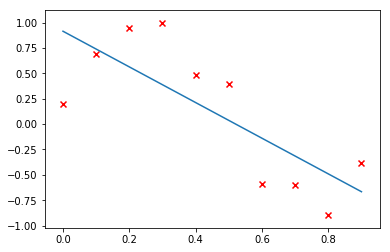

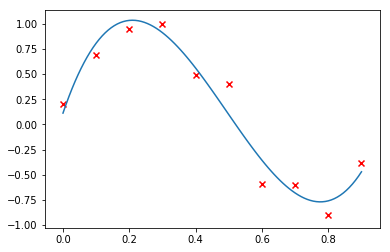

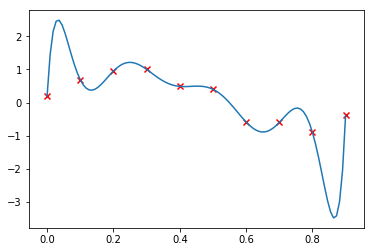

In [8]:
X = np.linspace(0,0.9,10).reshape(-1,1)
y = np.sin(X*2*np.pi)
y += np.array([0.2, 0.1, 0, 0.05, -0.1, 0.4, 0, 0.35, 0.05, 0.2]).reshape(-1,1)

poly_fitting(X, y, 0, 0, True)
poly_fitting(X, y, 1, 0, True)
poly_fitting(X, y, 3, 0, True)
poly_fitting(X, y, 9, 0, True)

print()

### 方差-偏差陷阱
在上面看到，阶数degree = 9时，曲线很好的逼进了每个点，但是很显然，得到的曲线并不是我们真正想要的曲线，在训练集上表现得很好但泛化性较差的模型我们称之为过拟合，它具有"较大方差"。类似的，像阶数为0和1时，曲线并没有拟合到所有数据上，这时我们称之为欠拟合，它具有"较大偏差"。  
尽管选择合适的多项式阶数能在上面的问题里凑效，但实际问题却往往不是称心如意。为此，上面已经实现了的正则化技巧将会派上用场，为了验证泛化能力，我们还要特地准备和训练集分布类似的验证集，以模型在验证集上的误差为准，测试找到最合适的正则化方法和系数。

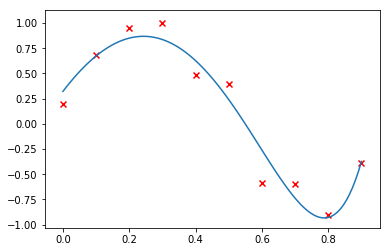

In [9]:
poly_fitting(X, y, 9, 0.001, True)

print()

### 回归问题的概率解释与贝叶斯回归
概率机器学习流派一直尝试使用概率方法解释机器学习问题和算法，事实上概率模型也的确在机器学习的发展上有着巨大的推动作用。很多机器学习算法就是完全基于统计概率建模的，比如NB朴素贝叶斯，贝叶斯网络，以及高斯混合模型、Fisher判别以及语音处理里常用的马尔科夫模型等。  
概率模型也可以解释很多经典的算法，比如一般的MSE损失函数优化，就可以通过引入额外的概率分布把MSE误差变换成概率，原优化问题就变成最大化对数概率似然。贝叶斯回归使用的技巧是，把真实数据点和函数模型之间的偏差视作噪声，我们假设噪声符合高斯分布，因为这个分布的自变量只有y这一维，我们可以写出一维情形的高斯分布函数$$ N(\mu,\sigma^2) = N(wx,\sigma^2)$$  
其中均值是函数模型的预测值，方差则视为超参，需要自行调节。对模型W和数据集中所有数据点，计算对数似然如下
$$ L(W) = log(\prod  _{n}^{i=1}\frac{1}{\sqrt{2\pi}\sigma}exp(-\frac{(y_i-wx)^2}{2\sigma}))=log(\frac{1}{2\pi^{\frac{n}{2}}\sigma^n})+\sum _{n}^{i=1}(-\frac{(y_i-wx)^2}{2\sigma}) $$
我们的目的是最大化对数似然，优化问题等价于$$ W=argmax\quad \sum _{n}^{i=1}(-\frac{(y_i-wx)^2}{2\sigma}) $$
我们会发现优化问题又变成了一个最小化MSE的过程，而在此之上，我们又能推导来自贝叶斯学派的贝叶斯线性回归。这部分知识相对更繁琐，我会在课后补充里详细讲解并实现贝叶斯线性回归。
### 回归问题实例
下面我们看一个基于上面的回归算法实现的实例，波士顿房价拟合。

In [10]:
# 回归问题实例，线性回归波士顿房价问题
from sklearn.datasets import load_boston
boston = load_boston()
descr = boston['DESCR']
data = boston['data']
feature_names = boston['feature_names']
target = boston['target']

X = data.copy()
y = target.copy()


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 0)

#数据标准化处理
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

X_poly, W = poly_fitting(X_train,y_train,1)
#计算训练集和测试集上的L1误差
out = X_poly.dot(W)
err = np.mean(np.abs(out-y_train.squeeze()))
print("L1 loss on training set: %.2f"%(err))

X_poly = dim_improve(X_test,1)
out = X_poly.dot(W)
err = np.mean(np.abs(out-y_test.squeeze()))
print("L1 loss on testing set: %.2f"%(err))

L1 loss on training set: 3.10
L1 loss on testing set: 3.84


注:任何使用多项式高维映射的技术都要进行适当的预处理，把数据**缩放**到0,1区间，否则原本很小的数值将变得非常巨大(指数爆炸)。如果数据在某些维度的分布稀疏或不均匀，可以尝试用对数坐标，或者PCA降维，以及其他度量学习的技术进行预处理

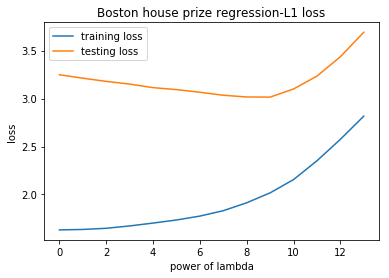

In [11]:
# 为了使用多项式回归，我们需要先把数据归一到0,1区间

min_max_scaler = MinMaxScaler()
X_01 = min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split( X_01, y, test_size = 0.2, random_state = 0)

# 使用二阶多项式，因为高阶项的存在，我们需要尝试不同的lambda正则化来加强模型泛化能力
train_loss = []
test_loss = []
lamda_list = [0.001*2**i for i in range(14)]

for lamda in lamda_list:

    X_poly, W = poly_fitting(X_train,y_train,2,lamda)
    #计算训练集和测试集上的L1误差
    out = X_poly.dot(W)
    err = np.mean(np.abs(out-y_train.squeeze()))
    train_loss.append(err)

    X_poly = dim_improve(X_test,2)
    out = X_poly.dot(W)
    err = np.mean(np.abs(out-y_test.squeeze()))
    test_loss.append(err)

plt.plot(train_loss,label='training loss')
plt.plot(test_loss,label='testing loss')
plt.title('Boston house prize regression-L1 loss')
plt.ylabel('loss')
plt.xlabel('power of lambda')
plt.legend()

### 分类决策
数据拟合有着很好的应用，我们可以在原数据上进行自己想要的函数形式拟合，从而得到一个很可能有意义的函数形式。但很多时候我们想要的不仅仅是拟合，我们或许会面临:得到数据集，每个数据都有自己的特征向量(或离散或连续)，并且有一个对应的分类标签，除此之外并没有任何其他信息，我们能不能学习到一个决策器模型帮助我们分类数据呢？  
我们当然可以把问题直接视为拟合问题，假设我们面临二分类问题，标签分别是0和1，如果把标签视为要回归的y，上面的算法一样可以跑起来，但是这并不是一个明智的做法，因为在0-1交界处的函数斜率可能会非常大，而除此之外的地方函数斜率非常小，这样的曲面很难用回归学习(用有参数模型固然很难，但后面我们会介绍一些能把这个任务做的很好的算法)。比较理智的做法是引入sigmoid函数 $$ \sigma(x)=\frac{1}{1+exp(-x)} $$

Text(0.5,1,'Sigmoid')

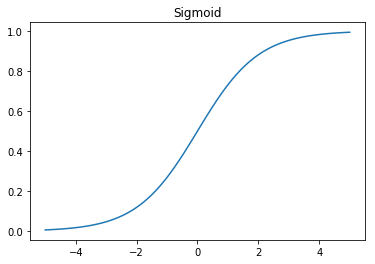

In [12]:
xx = np.linspace(-5,5,100)
yy = 1/(1+np.exp(-xx))
plt.plot(xx,yy)
plt.title('Sigmoid')

我们把sigmoid中的x用上面函数拟合里的y=f(x)换掉，则能让f(x)>0时y输出为0.5以上，<0时输出为0.5以下；因为sigmoid正具备着中间斜率大，两边斜率小的特征，如果把这个输出y视为新的输出函数值，则能把y的区间压缩到0到1之间，这样再对0-1标签回归可能会容易很多。  
除此之外，sigmoid还有容易求导的性质，计算一下就发现，$$ \frac{d\sigma}{dx} = y(1-y) $$
我们写出线性函数和sigmoid组合后的函数形式，计算它与目标标签的均方误差，就得到了分类问题的优化目标。
$$ y = \sigma(o) = \sigma(wx) $$
$$ argmin\quad L(w) = \frac{1}{2N}\sum_{i=1}^{n}(y_i-\hat{y_i})^2 $$
这个误差函数MSE因为非线性函数sigmoid存在，不再容易计算正规方程。但是我们一样有方法求解，比如上面已经提到的梯度下降，我们写出L关于w的梯度
$$ \frac{\partial{L}}{\partial{w}}=\frac{1}{N}\sum_{i=1}^{n}(y_i-\hat{y_i})y_i(1-y_i)x_i $$
写成代数形式就是 $$ \frac{\partial{L}}{\partial{w}}=\frac{1}{N}X^T((y_i-\hat{y_i})*y_i*(1-y_i))$$
我们只需要设置一个学习率alpha，再用梯度下降不断更新参数即可
$$ w \leftarrow w-\alpha\frac{\partial{L}}{\partial{w}}$$
不过基于MSE做回归虽然能跑起来，但是存在一个问题，假设有样本标签为1，但是被错分在了0；这时sigmoid对它的输出值为接近于0，处于sigmoid的两端，但是**sigmoid在两端的导数是非常小的**。这样下去尽管参数在更新，但更新速度非常的慢，这自然不是我们需要的。我们希望，数据被误判的程度越大，更新速率就越大。为此我们可能需要更好的优化目标。如果我们把sigmoid输出的数值，看做数据分类为1的概率，则可以从最大化对数概率的角度考虑。
$$ argmax\quad L(w)=\sum_{i=1}^{n}(y_i log(\sigma(o))+(1-y_i) log(1-\sigma(o)))=\sum_{i=1}^{n}(y_i log(p)+(1-y_i) log(1-p)) $$
这个loss又被称为BCEloss，二分类交叉熵。log函数的引入会让输出越远离目标，就有越大的斜率。对这个新的函数计算w的梯度
$$ \frac{\partial{L}}{\partial{w}}=\sum_{i=1}^{n}(\frac{y_i p(1-p)}{p}-\frac{(1-y_i) p(1-p)}{1-p})x_i=
\sum_{i=1}^{n}(y_i (1-p)-(1-y_i) p)x_i=\sum_{i=1}^{n}(y_i-p)x_i$$
梯度更适合训练，目标与实际的相差越大，对应的参数得到的变化量也就越大。上面的基于线性回归进行二分类的技术称为logistic回归，我们可以编程实现一下。

In [13]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class Logisic:
    def fit(self,X,y,lr = 0.01,max_iter = 500, plot_every_iters = 100):
        '''
        接收数据特征X和标签y，需要X为NxM的二维numpy array
        y为数值为0-1的一维numpy array，学习率和迭代次数自行调节
        '''
        n,m = X.shape
        y = y.reshape(-1,1)
        self.W = np.random.rand(m,1)
        self.b = np.random.rand(1)
        
        for iters in range(max_iter):
            p = sigmoid(X.dot(self.W)+self.b)  # 计算概率
            if (iters+1)%plot_every_iters==0:
                err = np.mean(-y*np.log(p)-(1-y)*np.log(1-p))  # BCE loss
                print("Iteration: %d, BCE loss: %.2f"%(iters+1,err))
            db = y-p # BCE loss的梯度计算
            dw = X.T.dot(db)/n
            db = np.sum(db)/n
            # 最大化对数似然，使用梯度上升法
            self.b += lr*db
            self.W += lr*dw
    
    def predict(self, X):
        '''
        输入x为任意n，固定m的二维numpy array
        '''
        return np.round(sigmoid(X.dot(self.W)+self.b))

我们用乳腺癌二分类数据集来测试算法性能，一般在处理真实数据前，为了让数据易于学习，需要先对数据标准化处理。

In [14]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
descr = cancer['DESCR']
data = cancer['data']
feature_names = cancer['feature_names']
target = cancer['target']
target_names = cancer['target_names']

In [15]:
X = data.copy()
y = target.copy()

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [16]:
model = Logisic()
model.fit(X_train,y_train,0.01,1000)

Iteration: 100, BCE loss: 0.69
Iteration: 200, BCE loss: 0.25
Iteration: 300, BCE loss: 0.19
Iteration: 400, BCE loss: 0.16
Iteration: 500, BCE loss: 0.14
Iteration: 600, BCE loss: 0.13
Iteration: 700, BCE loss: 0.12
Iteration: 800, BCE loss: 0.11
Iteration: 900, BCE loss: 0.11
Iteration: 1000, BCE loss: 0.10


In [17]:
accuracy_score(model.predict(X_test).reshape(-1),y_test)

0.9300699300699301

由于训练集和测试集划分的随机性，测试集上的正确率可能有细微差别，不过无伤大雅；我们可以看见逻辑回归能够很好的处理这个二分类问题，并取得90per以上的正确率。因为breast cancer数据集有比较好的**线性可分**性质，逻辑回归可以得到比较理想的结果。但不免有时会出现不是线性可分的数据，这时我们也可以用上面函数拟合时使用的多项式回归技术，把原数据做**升维**处理，再尝试进行线性划分。当然，分类问题也可以用正则化来避免过拟合。

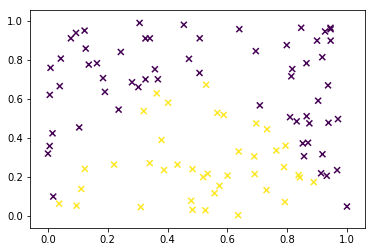

In [18]:
# 设计不是线性可分的数据集
X = np.random.rand(2,100)
y = (X[1]<np.sin(X[0]*np.pi)*0.7)
y = y.astype(np.int)
X = X.T
plt.scatter(X[:,0].squeeze(),X[:,1].squeeze(),c=y, marker='x')

In [19]:
def decision_plain(model, low1, upp1, low2, upp2):
    x_axis = np.linspace(low1,upp1,100)
    y_axis = np.linspace(low2,upp2,100)
    xx, yy = np.meshgrid(x_axis, y_axis)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            
            Z[i][j] = model.predict(np.array([xx[i][j],yy[i][j]]))
    plt.figure(figsize=(8,6), dpi=80)
    colors = ['aquamarine','palegoldenrod']
    plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(colors))

Iteration: 1000, BCE loss: 0.44
Iteration: 2000, BCE loss: 0.41
Iteration: 3000, BCE loss: 0.40
Iteration: 4000, BCE loss: 0.40
Iteration: 5000, BCE loss: 0.40
accuracy: 0.81


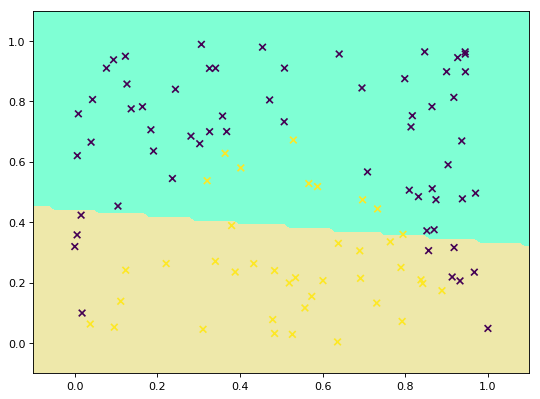

In [20]:
model = Logisic()
model.fit(X,y,0.1,5000,1000)
print("accuracy:",accuracy_score(model.predict(X).reshape(-1),y))
decision_plain(model,-0.1,1.1,-0.1,1.1)
plt.scatter(X[:,0].squeeze(),X[:,1].squeeze(),c=y, marker='x')

In [21]:
def decision_plain_poly(model, deg, low1, upp1, low2, upp2):
    x_axis = np.linspace(low1,upp1,100)
    y_axis = np.linspace(low2,upp2,100)
    xx, yy = np.meshgrid(x_axis, y_axis)
    Z = np.zeros((100,100))
    for i in range(100):
        for j in range(100):
            inpt = np.array([[xx[i][j],yy[i][j]]])
            inpt = dim_improve(inpt, deg)
            Z[i][j] = model.predict(inpt)
    plt.figure(figsize=(8,6), dpi=80)
    colors = ['aquamarine','palegoldenrod']
    plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(colors))

In [22]:
# 进行多项式维度提升
deg = 4
X_poly = dim_improve(X, deg)

Iteration: 1000, BCE loss: 0.33
Iteration: 2000, BCE loss: 0.28
Iteration: 3000, BCE loss: 0.25
Iteration: 4000, BCE loss: 0.23
Iteration: 5000, BCE loss: 0.21
accuracy: 0.94


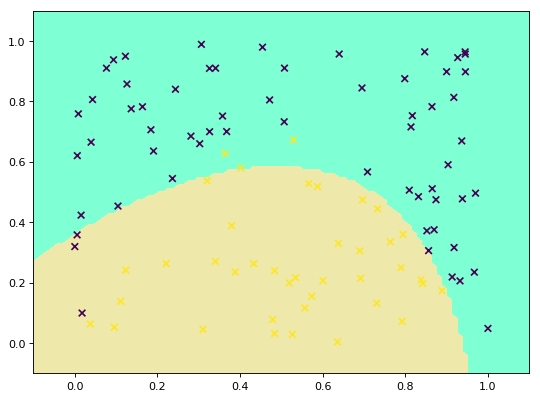

In [23]:
model = Logisic()
model.fit(X_poly,y,0.1,5000,1000)
print("accuracy:",accuracy_score(model.predict(X_poly).reshape(-1),y))
decision_plain_poly(model,deg,-0.1,1.1,-0.1,1.1)
plt.scatter(X[:,0].squeeze(),X[:,1].squeeze(),c=y, marker='x')

一个基本的思想是，数据在通过某种映射被映射到高维空间后，一般会变得更线性可分。这个映射也不必一定是多项式，也可以是高斯函数，sigmoid函数等，这个技巧又被称为映射，我们将在后面的学习中更详细的介绍它们。但是以多项式为代表的这些映射都变临一个问题，即维度灾难。上面的例子我们在原本的二维空间里使用4阶多项式，这就把数据空间扩大到了10维以上。如果我们的数据维度像上面的乳腺癌数据集一样，原本就拥有30个维度，那么在此之上使用多项式产生的新维度将非常多，这显然是无法接受的。为此，我们或许需要更好的非线性方法，这些方法我们在后面的学习中将会进一步介绍。

### Fisher判别
Fisher判别器没有使用非线性的技巧，而是纯粹基于线性变换进行的分类算法。首先还是做一个线性变换y=wx，然后我们希望同类样本的y相似，而不同样本的y差别较大。如果这个假设在问题上合理，则我们就能用一类样本的y的均值作为类别中心，以样本离各聚类中心的距离来进行数据分类。  
首先定义类间距离和类内距离，类间距就是两个类中心的距离，类内距就是所有数据点到类中心的距离均值
$$J_0=((\mu_1-\mu_0)W)^T((\mu_1-\mu_0)W)=W^T(\mu_1-\mu_0)^T(\mu_1-\mu_0)W$$
$$J_1=((X-\mu)W)^T((X-\mu)W)=W^T(X-\mu)^T(X-\mu)W$$
我们设$$S_1=(X-\mu)^T(X-\mu),S_0 = (\mu_1-\mu_0)^T(\mu_1-\mu_0)$$
有了这两个量就可以自己定义损失函数了，一种能保证数据规模不会影响loss的方法是设J1=1，最大化J0。即$$J=W^TS_0W \quad s.t.\quad W^TS_1W=1$$
这个问题直接用拉格朗日乘子法就能求解，写出拉格朗日函数
$$ L(W,\lambda)=W^TS_0W-\lambda (W^TS_1W-1) $$
计算偏导并让它等于0，就得到
$$ \frac{\partial{L}} {\partial{W}}=2W^TS_0W-2\lambda W^TS_1=0 $$
$$ S_0W=\lambda S_1W $$
$$ S_1^{-1}S_0W=\lambda W $$
和PCA的推导很类似，即特征值分解。因为我们要最大化目标函数，我们取S_1^{-1}S_0最大的特征向量，就得到了最优解W。计算均值就能进行判别。如果我们取前d个最大的特征向量，就能实现从原数据域降维到d维的线性变换矩阵。  

In [24]:
class Fisher:
    def fit(self,X,y):
        '''
        接收数据特征X和标签y，需要X为NxM的二维numpy array
        y为数值为0-1的一维numpy array
        '''
        # 分为正负样本
        X_1 = X[np.where(y==1)]
        X_0 = X[np.where(y==0)]
        # 计算均值
        mu1 = np.mean(X_1,axis = 0)
        mu0 = np.mean(X_0,axis = 0)
        self.mu1 = mu1
        self.mu0 = mu0
        # 类内散度
        S1 = (X_1-mu1).T.dot((X_1-mu1))
        # 类间散度
        S0 = (mu1-mu0).reshape(-1,1).dot((mu1-mu0).reshape(1,-1))
        # 特征值分解
        S = np.linalg.inv(S1).dot(S0)
        lamda,V=np.linalg.eigh(S)
        #取前dim个最大的特征值对应的特征向量
        index=np.argsort(-lamda)[0]
        V_selected=V[:,index]
        self.W = V_selected
        return self.W
        
    
    def predict(self, X):
        '''
        输入x为任意n，固定m的numpy array
        '''
        n,m = X.shape
        dy = np.concatenate([(X-self.mu0).dot(self.W),
                             (X-self.mu1).dot(self.W)])
        dy = np.abs(dy.reshape(2,n))
        return np.argmin(dy.T,axis = 1)

In [25]:
model = Fisher()
model.fit(X_train,y_train)
accuracy_score(model.predict(X_test).squeeze(),y_test)

0.8811188811188811

如果要评价Fisher线性判别分析和逻辑回归孰优孰劣，一般逻辑回归在分类问题上的表现都会好过线性判别分析。因为线性判别分析就是把数据线性投影到1维，投影能解决的问题，逻辑回归都能解决。但是线性判别分析可以实现有标签的数据降维，我们认为在有标签时，LDA的表现一定好过PCA在无标签下的表现。降维不仅可以实现非常好看的数据可视化，很多时候还可以帮助模型训练。而逻辑回归，最大的作用是搭建神经网络。

### 多分类
在样本类别较少时，我们可以采取1对多的构造方式，对N个类别，要搭建N个二分类器，预测时进行N次计算，选择置信度最大的分类。在样本类别很多时，1对多的方式不但要构造多个分类器，还会面临样本不均衡的问题，这时我们可以随机构建多个多对多分类器。对数据集进行M次划分，生成M个判别器。每个判别器会把类别处理为一个编码，比如对某个类，5个判别器分别预测为-+-++，则编码为01011。在用这M个模型共同预测时，会生成M个结果组成一个新的码，最终通过计算海明/欧式距离选择距离最小的类别作为最终分类结果。比如5个判别器对样本预测为00101，而每个类别对应的编码为01011,10010,01101,00110。我们选择海明距离最小的01101，第三类作为分类结果。